# Project: Image classification

G4: Mónia, Moritz, Fabian

## Preparations

### Import needed libaries

In [75]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn import metrics
from keras.backend import clear_session
from keras.src.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Softmax, BatchNormalization, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

%matplotlib inline

### Load the CIFAR-10

More information: [CIFAR-10 at cs.toronto.edu](https://www.cs.toronto.edu/~kriz/cifar.html)

In [76]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Check provided dataset

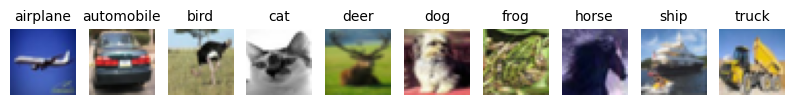

In [77]:
# Create a figure and axes for plotting
fig, axes = plt.subplots(1, 10, figsize=(10, 2))

# Flatten the axes array for easier indexing
axes = axes.ravel()

# Get the unique classes in CIFAR-10
classes = np.unique(y_train)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Loop through each class
for i, cls in enumerate(classes):
    # Filter images belonging to the current class
    class_indices = np.where(y_train == cls)[0]

    # Randomly select 1 image from the filtered indices
    random_idx = np.random.choice(class_indices, 1, replace=False)[0]

    axes[i].imshow(x_train[random_idx])
    axes[i].axis('off')
    axes[i].set_title(class_names[i], fontsize=10)

# Display the plot
plt.show()

### Preprocessing

As images are arrays of RGB colors, with a range from 0 - 255 we're deviding the colors by 255 to get normalized data.

Labels are converted to the One-hot encoded format

In [78]:
# Normalizing
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding format
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Reusable methods

#### Reports

##### Confusion matrix

The confusion matrix shows the counts of true positives, true negatives, false positives, and false negatives for each class, revealing how well the model predicts different classes.

In [79]:
def show_confusion_matrix(y_test_data, prediction, name):
    """
    Args:
        y_test_data (numpy.ndarray): The true labels of the test data.
        prediction (numpy.ndarray): The predicted labels of the test data.
        name (str): The name of the file for saving the confusion matrix image (saved as a PNG).
    Returns:
        None: The function displays the confusion matrix and saves it as a PNG file.
    """

    prediction = np.argmax(prediction, axis=1)
    gt = np.argmax(y_test_data, axis=1)

    cm = metrics.confusion_matrix(gt, prediction)
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(f"output/confusion_matrix_{name}.png")
    plt.show()

##### Comparison Graph

Generates and displays a comparison graph of training and validation loss and accuracy.

In [80]:
def show_compare_graph(cnn_history, name):
    """
    Args:
        cnn_history (History object): The history object returned by the `model.fit()` method, containing loss and accuracy data.
        name (str): The name of the file for saving the comparison graph image (saved as a PNG).

    Returns:
        None: The function displays the comparison graph and saves it as a PNG file.
    """

    plt.title('Loss / Accuracy')
    plt.plot(cnn_history.history['loss'], color='#ff8080', label='train loss')
    plt.plot(cnn_history.history['accuracy'], color='#80ff80', label='train accuracy')
    plt.plot(cnn_history.history['val_loss'], color='#b30000', label='val loss')
    plt.plot(cnn_history.history['val_accuracy'], color='#008f00', label='val accuracy')
    plt.legend()
    plt.savefig(f"output/compare_graph_{name}.png")
    plt.show()

##### Classification Report

Generates and prints a classification report for model predictions, comparing the predicted and actual labels.

In [81]:
def show_classification_report(y_test_data, prediction):
    """
    Args:
        y_test_data (numpy.ndarray): Ground truth labels in one-hot encoded format.
        prediction (numpy.ndarray): Model predictions (as probabilities or logits), which will be converted to class predictions.

    Returns:
        None: The function prints the classification report to the console, including precision, recall, F1-score, and support.
    """

    prediction = np.argmax(prediction, axis=1)
    y_data_argmax = np.argmax(y_test_data, axis=1)
    print(metrics.classification_report(y_data_argmax, prediction))

##### Prediction Info

Randomly selects and displays images from the test dataset, showing the actual and predicted labels for each image.

In [82]:
def show_prediction_info(y_test_data, x_test_data, prediction):
    """
    Randomly selects and displays images from the test dataset, showing the actual and predicted labels for each image.

    Args:
        y_test_data (numpy.ndarray): Ground truth labels in one-hot encoded format.
        x_test_data (numpy.ndarray): Test images corresponding to the ground truth labels.
        prediction (numpy.ndarray): Model predictions (as probabilities or logits), which will be converted to class predictions.

    Returns:
        None: The function displays three images from the test set, with predicted and actual labels.
    """

    for i in range(3):
        index = np.random.randint(0, len(y_test_data))
        plt.figure(figsize=(2, 2))
        plt.imshow(x_test_data[index, :])
        plt.xlabel(f"Predicted: {class_names[np.argmax(prediction[index])]}", fontsize=10)
        plt.ylabel(class_names[np.argmax(y_test_data[index])], fontsize=10)
        plt.show()

##### Evaluation Report

Evaluates the performance of a CNN model on test data (`x_test` and `y_test`) and prints the test accuracy and loss

In [83]:
def show_evaluation_report(cnn_model, y_test_data, x_test_data):
    """
    Args:
        cnn_model (keras.Model): The trained CNN model used to generate predictions on the test data.
        y_test_data (numpy.ndarray): The true labels of the test data.
        x_test_data (numpy.ndarray): Test images used for evaluating the model.
    Returns:
        None: Prints the Test accuracy and Test loss.
    """

    test_loss, test_acc = cnn_model.evaluate(x_test_data, y_test_data, verbose=0)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)

##### Evaluate Model

 Evaluates the performance of a CNN model by generating predictions and displaying key metrics and visualizations.

In [84]:
def evaluate_model(cnn_model, cnn_history, x_test_data, y_test_data, name):
    """
    Args:
        cnn_model (keras.Model): The trained CNN model used to generate predictions on the test data.
        cnn_history (History object): The training history of the CNN model, returned by the `model.fit()` method.
        x_test_data (numpy.ndarray): Test images used for evaluating the model.
        y_test_data (numpy.ndarray): Ground truth labels for the test images, in one-hot encoded format.
        name (str): The name used for saving the output files (confusion matrix and graphs).

    Returns:
        None: The function generates and displays visualizations (confusion matrix, accuracy/loss graph)
              and prints performance metrics (classification report). Images from the test set are shown
              with predicted and actual labels.
    """

    prediction = cnn_model.predict(x_test_data)

    show_confusion_matrix(y_test_data, prediction, name)
    show_compare_graph(cnn_history, name)
    show_classification_report(y_test_data, prediction)
    show_prediction_info(y_test_data, x_test_data, prediction)
    show_evaluation_report(cnn_model, y_test_data, x_test_data)

#### Model Helper

##### Early Stopping

This returns an EarlyStopping callback, which is used to stop model training when a monitored metric stops improving for a specified number of epochs (patience), optionally restoring the best model weights.

In [85]:
def early_stopping_callback(patience=5, monitor='val_loss', restore_best_weights=True):
    """
    Args:
        patience (int, optional): Number of epochs with no improvement after which training will be stopped. Defaults to 5.
        monitor (str, optional): Metric to be monitored for improvement. Defaults to 'val_loss'.
        restore_best_weights(bool, optional): Whether to restore model weights from the epoch with the best value of the monitored metric. Defaults to True.

    Returns:
        EarlyStopping: An EarlyStopping callback object.
    """

    return EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=restore_best_weights)

##### Resize Images

Resize an image set to a defined size

In [86]:
def resize_images(images, new_size=(75, 75)):
    """
    Resizes a list of images to a specified size.

    Args:
      images: A list of NumPy arrays representing images.
      new_size: A tuple (width, height) specifying the new size.

    Returns:
      A list of resized images as NumPy arrays.
    """
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
        resized_images.append(resized_image)
    return np.array(resized_images)

##### Image Data Generator

Returns an `ImageDataGenerator` object configured for data augmentation with specified parameters for random image rotations, width and height shifts, and horizontal flips.

In [87]:
def image_data_generator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True):
    """
    Args:
      rotation_range: Specifies the range of random rotations in degrees
      width_shift_range: Defines the maximum horizontal shift as a fraction of the image width
      height_shift_range: Defines the maximum horizontal shift as a fraction of the image height
      horizontal_flip: Randomly flips images horizontally

    Return:
      A ImageDataGenerator Object
    """

    return ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        horizontal_flip=horizontal_flip)

## Models

### Model 1

A simple sequential model with one convolutional layer followed by flattening and two dense layers.

In [31]:
clear_session()

In [32]:
# Define the CNN model
model = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 32 filters
    Flatten(),  # Flatten the feature maps
    Dense(100, activation='relu'),  # Add a dense layer with 100 units
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [33]:
# Compile model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train, epochs=60, batch_size=512, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1815 - loss: 2.2309 - val_accuracy: 0.2573 - val_loss: 2.0197
Epoch 2/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3026 - loss: 1.9803 - val_accuracy: 0.3137 - val_loss: 1.9515
Epoch 3/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3399 - loss: 1.8785 - val_accuracy: 0.3737 - val_loss: 1.8120
Epoch 4/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3629 - loss: 1.8132 - val_accuracy: 0.3763 - val_loss: 1.7778
Epoch 5/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3761 - loss: 1.7785 - val_accuracy: 0.3838 - val_loss: 1.7572
Epoch 6/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3912 - loss: 1.7474 - val_accuracy: 0.3873 - val_loss: 1.7384
Epoch 7/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4015 - loss: 1.7211 - val_accuracy: 0.4034 - val_loss: 1.6923
Epoch 8/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4074 - loss: 1.6958 - val_accuracy: 0.4185 - v

#### Evaluation

Model 1 achieved a relatively low accuracy on the test set, indicating that its simple architecture may not be sufficient to capture the complexity of the CIFAR-10 dataset. Further experimentation with more layers or different architectures could be beneficial.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


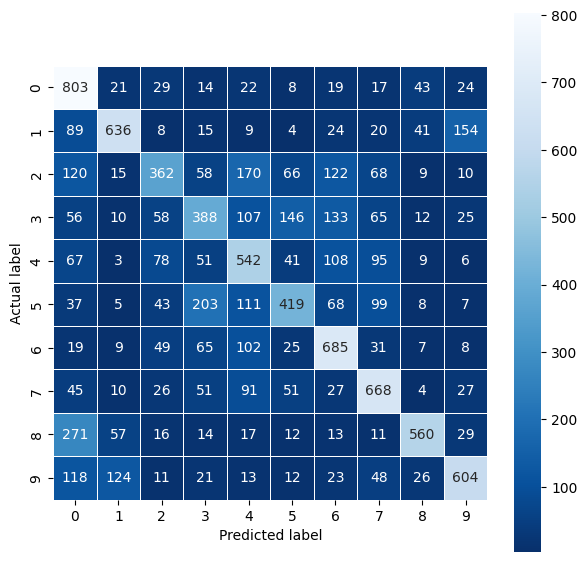

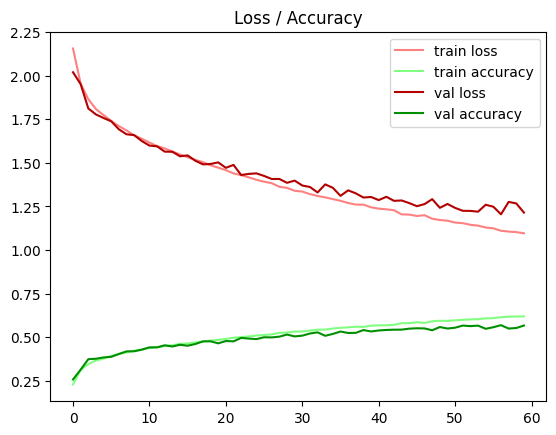

              precision    recall  f1-score   support

           0       0.49      0.80      0.61      1000
           1       0.71      0.64      0.67      1000
           2       0.53      0.36      0.43      1000
           3       0.44      0.39      0.41      1000
           4       0.46      0.54      0.50      1000
           5       0.53      0.42      0.47      1000
           6       0.56      0.69      0.62      1000
           7       0.60      0.67      0.63      1000
           8       0.78      0.56      0.65      1000
           9       0.68      0.60      0.64      1000

    accuracy                           0.57     10000
   macro avg       0.58      0.57      0.56     10000
weighted avg       0.58      0.57      0.56     10000



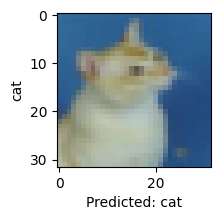

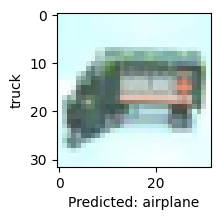

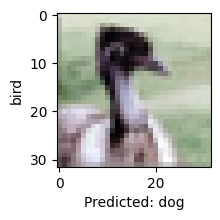

Test accuracy: 0.5666999816894531
Test loss: 1.2147576808929443


In [34]:
evaluate_model(model, history, x_test, y_test, 'model_1')

As we can see, the result is not very good. The loss is higher as the accuracy

In [35]:
clear_session()

### Model 2

This model introduces BatchNormalization and Dropout, along with an additional convolutional layer compared to Model 1.

In [36]:
# Define the CNN model
model2 = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25
    Flatten(),  # Flatten the feature maps
    Dense(100, activation='relu'),  # Add a dense layer with 100 units
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [37]:
# Compile model
model2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history2 = model2.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.3038 - loss: 2.0509 - val_accuracy: 0.1304 - val_loss: 2.5025
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.4686 - loss: 1.4812 - val_accuracy: 0.1845 - val_loss: 2.8155
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5273 - loss: 1.3208 - val_accuracy: 0.1918 - val_loss: 2.6831
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5613 - loss: 1.2180 - val_accuracy: 0.3419 - val_loss: 1.9009
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5934 - loss: 1.1404 - val_accuracy: 0.4950 - val_loss: 1.4241
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6214 - loss: 1.0632 - val_accuracy: 0.5777 - val_loss: 1.2196
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6469 - loss: 1.0031 - val_accuracy: 0.6068 - val_loss: 1.0998
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6604 - loss: 0.9506 - val_accuracy: 0.6152 

#### Evaluation

Model 2 showed some improvement over Model 1, likely due to the addition of BatchNormalization and Dropout, which help to prevent overfitting. However, there is still room for improvement in terms of accuracy.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


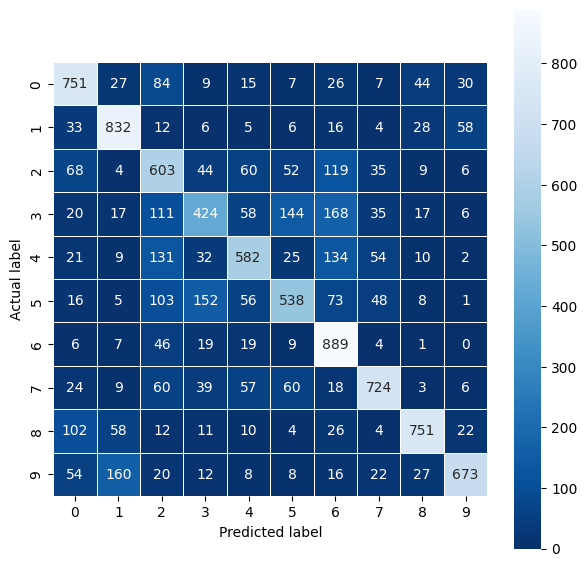

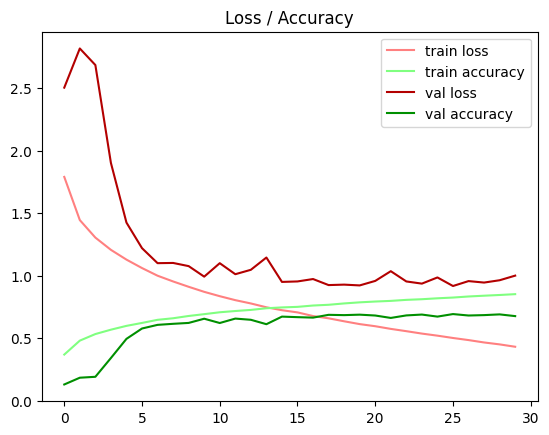

              precision    recall  f1-score   support

           0       0.69      0.75      0.72      1000
           1       0.74      0.83      0.78      1000
           2       0.51      0.60      0.55      1000
           3       0.57      0.42      0.49      1000
           4       0.67      0.58      0.62      1000
           5       0.63      0.54      0.58      1000
           6       0.60      0.89      0.72      1000
           7       0.77      0.72      0.75      1000
           8       0.84      0.75      0.79      1000
           9       0.84      0.67      0.75      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.67     10000
weighted avg       0.68      0.68      0.67     10000



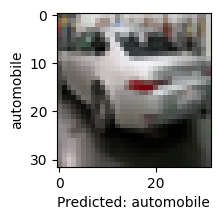

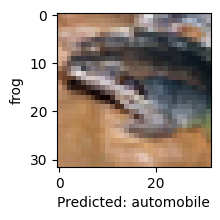

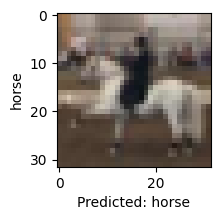

Test accuracy: 0.6766999959945679
Test loss: 1.0001987218856812


In [38]:
evaluate_model(model2, history2, x_test, y_test, 'model_2')

In [39]:
clear_session()

### Model 3

Increases complexity with two sets of convolutional layers (64 and 128 filters), BatchNormalization, MaxPooling, and Dropout.

In [40]:
# Define the CNN model
model3 = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25
    Flatten(),  # Flatten the feature maps
    Dense(100, activation='relu'),  # Add a dense layer with 100 units
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [41]:
# Compile model
model3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history3 = model3.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 187ms/step - accuracy: 0.2993 - loss: 2.1286 - val_accuracy: 0.1000 - val_loss: 2.5791
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.4847 - loss: 1.4382 - val_accuracy: 0.1219 - val_loss: 2.7806
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.5414 - loss: 1.2799 - val_accuracy: 0.1959 - val_loss: 2.5754
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5819 - loss: 1.1696 - val_accuracy: 0.3103 - val_loss: 1.9372
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.6126 - loss: 1.0821 - val_accuracy: 0.4745 - val_loss: 1.4859
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.6412 - loss: 1.0137 - val_accuracy: 0.5836 - val_loss: 1.1673
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.6511 - loss: 0.9762 - val_accuracy: 0.6184 - val_loss: 1.0625
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.6726 - loss: 0.9140 - val_accuracy: 0.6

#### Evaluation

Model 3 increased depth resulted in a significant jump in accuracy compared to the previous models. The addition of more convolutional layers allowed the model to learn more complex features.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


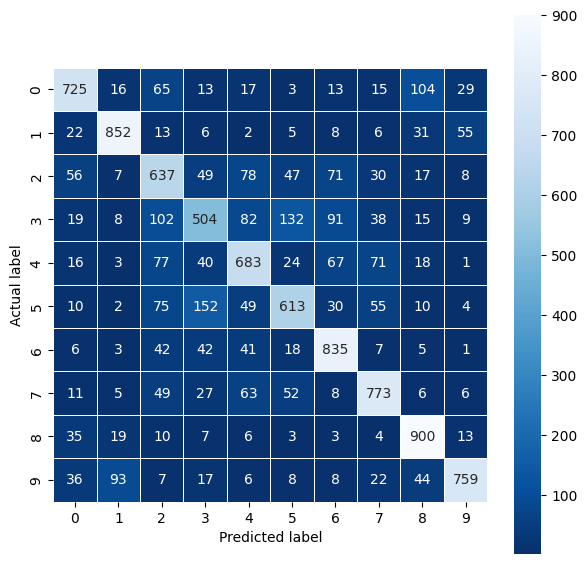

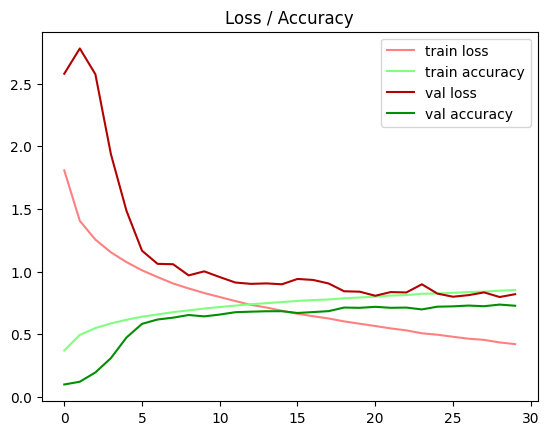

              precision    recall  f1-score   support

           0       0.77      0.72      0.75      1000
           1       0.85      0.85      0.85      1000
           2       0.59      0.64      0.61      1000
           3       0.59      0.50      0.54      1000
           4       0.67      0.68      0.67      1000
           5       0.68      0.61      0.64      1000
           6       0.74      0.83      0.78      1000
           7       0.76      0.77      0.76      1000
           8       0.78      0.90      0.84      1000
           9       0.86      0.76      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



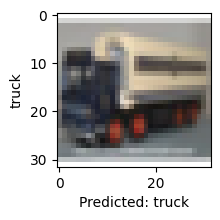

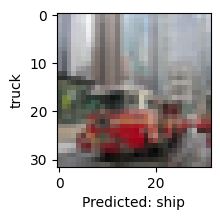

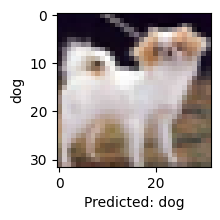

Test accuracy: 0.7281000018119812
Test loss: 0.8202992081642151


In [42]:
evaluate_model(model3, history3, x_test, y_test, 'model_3')

In [43]:
clear_session()

### Model 4

Similar to Model 3 but replaces Flatten with GlobalAveragePooling2D for dimensionality reduction.

In [44]:
# Define the CNN model
model4 = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25
    GlobalAveragePooling2D(),  # Add a global average pooling layer
    Flatten(),  # Flatten the feature maps
    Dense(100, activation='relu'),  # Add a dense layer with 100 units
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [45]:
# Compile model
model4.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history4 = model4.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.2818 - loss: 1.9947 - val_accuracy: 0.0949 - val_loss: 2.3800
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.4189 - loss: 1.6172 - val_accuracy: 0.1351 - val_loss: 2.6647
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.4700 - loss: 1.4841 - val_accuracy: 0.1282 - val_loss: 3.0215
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.4951 - loss: 1.4073 - val_accuracy: 0.1853 - val_loss: 3.0547
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5170 - loss: 1.3483 - val_accuracy: 0.2535 - val_loss: 2.3898
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.5375 - loss: 1.2985 - val_accuracy: 0.3585 - val_loss: 1.7071
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5428 - loss: 1.2725 - val_accuracy: 0.4794 - val_loss: 1.4437
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.5638 - loss: 1.2235 - val_accuracy: 0.52

#### Evaluation

Model 4, with GlobalAveragePooling2D, achieved comparable accuracy to Model 3 while potentially reducing the number of parameters. This suggests that GlobalAveragePooling2D can be an effective alternative to Flatten in some cases.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


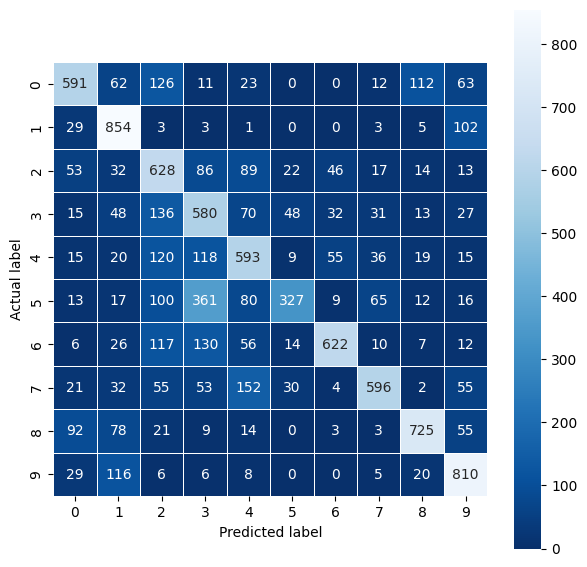

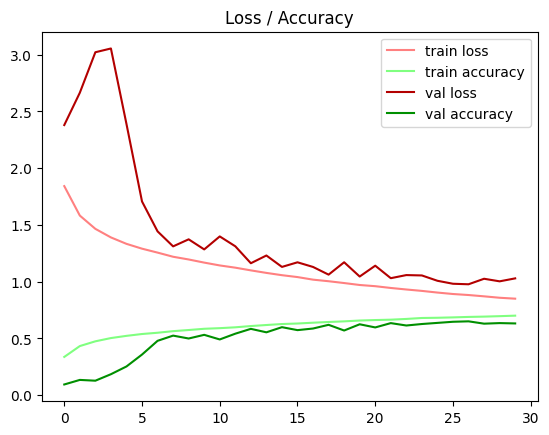

              precision    recall  f1-score   support

           0       0.68      0.59      0.63      1000
           1       0.66      0.85      0.75      1000
           2       0.48      0.63      0.54      1000
           3       0.43      0.58      0.49      1000
           4       0.55      0.59      0.57      1000
           5       0.73      0.33      0.45      1000
           6       0.81      0.62      0.70      1000
           7       0.77      0.60      0.67      1000
           8       0.78      0.72      0.75      1000
           9       0.69      0.81      0.75      1000

    accuracy                           0.63     10000
   macro avg       0.66      0.63      0.63     10000
weighted avg       0.66      0.63      0.63     10000



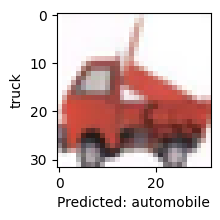

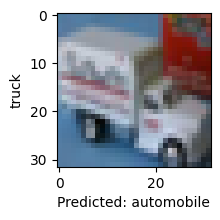

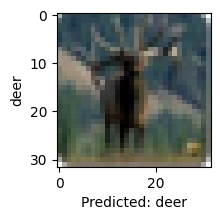

Test accuracy: 0.6326000094413757
Test loss: 1.0295488834381104


In [46]:
evaluate_model(model4, history4, x_test, y_test, 'model_4')

### Model 5

Uses the Adam optimizer instead of SGD, showing potential improvements in training efficiency and accuracy.

In [47]:
# Define the CNN model
model5 = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25
    GlobalAveragePooling2D(),  # Add a global average pooling layer
    Flatten(),  # Flatten the feature maps
    Dense(100, activation='relu'),  # Add a dense layer with 100 units
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [48]:
# Compile model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history5 = model5.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.4084 - loss: 1.6325 - val_accuracy: 0.1000 - val_loss: 2.8072
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.6169 - loss: 1.0761 - val_accuracy: 0.1000 - val_loss: 3.7698
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.6868 - loss: 0.8865 - val_accuracy: 0.1040 - val_loss: 4.4329
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.7377 - loss: 0.7498 - val_accuracy: 0.1100 - val_loss: 3.3540
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.7701 - loss: 0.6521 - val_accuracy: 0.2136 - val_loss: 2.4761
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.8043 - loss: 0.5641 - val_accuracy: 0.6076 - val_loss: 1.1082
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8295 - loss: 0.4978 - val_accuracy: 0.7377 - val_loss: 0.7468
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8514 - loss: 0.4359 - val_accuracy: 0.734

#### Evaluation

The use of the Adam optimizer in Model 5 led to faster convergence and potentially better accuracy compared to SGD in previous models. Adam's adaptive learning rates can be beneficial for complex datasets.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


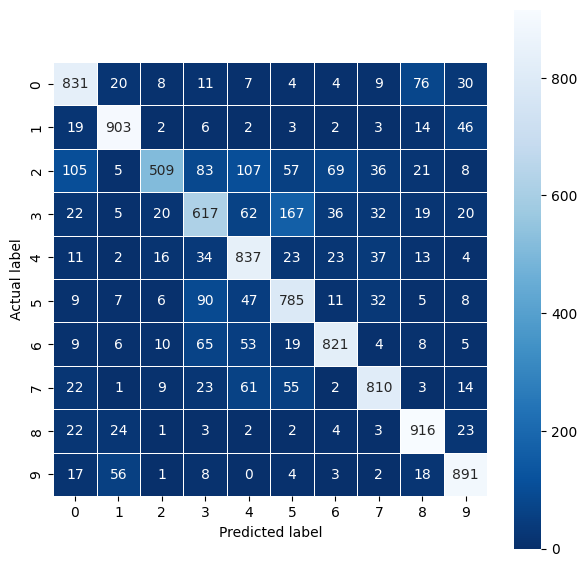

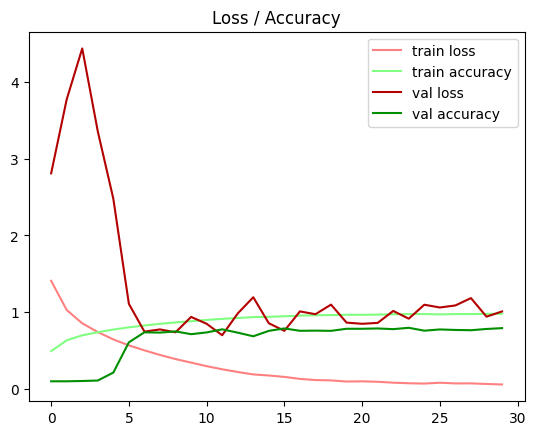

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1000
           1       0.88      0.90      0.89      1000
           2       0.87      0.51      0.64      1000
           3       0.66      0.62      0.64      1000
           4       0.71      0.84      0.77      1000
           5       0.70      0.79      0.74      1000
           6       0.84      0.82      0.83      1000
           7       0.84      0.81      0.82      1000
           8       0.84      0.92      0.88      1000
           9       0.85      0.89      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



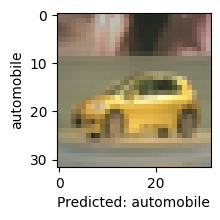

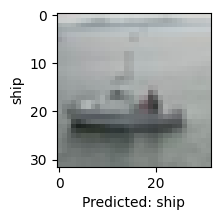

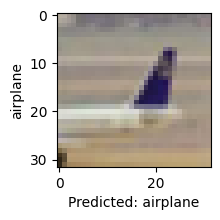

Test accuracy: 0.7919999957084656
Test loss: 1.0096062421798706


In [49]:
evaluate_model(model5, history5, x_test, y_test, 'model_5')

### Model 6

 Incorporates EarlyStopping to prevent overfitting and potentially improve generalization.

In [50]:
# Define the CNN model
model6 = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25
    GlobalAveragePooling2D(),  # Add a global average pooling layer
    Flatten(),  # Flatten the feature maps
    Dense(100, activation='relu'),  # Add a dense layer with 100 units
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [51]:
# Compile model
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history6 = model6.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test), callbacks=[early_stopping_callback()])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.3919 - loss: 1.6863 - val_accuracy: 0.1266 - val_loss: 2.8082
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.6114 - loss: 1.0866 - val_accuracy: 0.1032 - val_loss: 3.2749
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.6841 - loss: 0.8969 - val_accuracy: 0.1000 - val_loss: 4.3313
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.7386 - loss: 0.7530 - val_accuracy: 0.1024 - val_loss: 4.2826
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7710 - loss: 0.6577 - val_accuracy: 0.1814 - val_loss: 2.7165
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8019 - loss: 0.5720 - val_accuracy: 0.4901 - val_loss: 1.3823
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8243 - loss: 0.5104 - val_accuracy: 0.7129 - val_loss: 0.8146
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8478 - loss: 0.4441 - val_accuracy: 0.746

#### Evaluation

Model 6 demonstrated the effectiveness of EarlyStopping in preventing overfitting. By stopping the training process early, it may have achieved a better balance between training accuracy and generalization.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


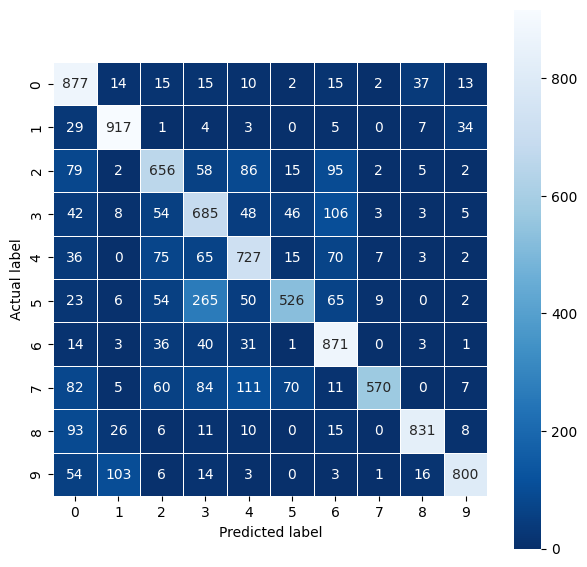

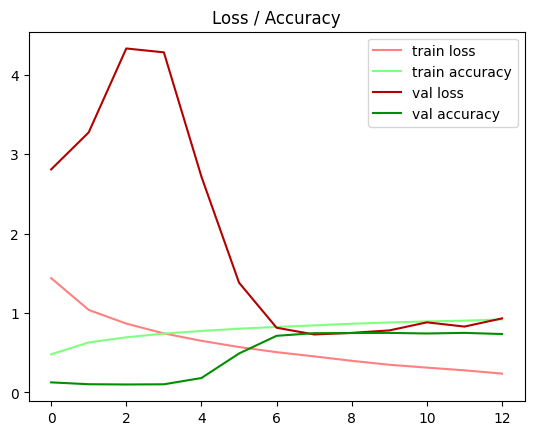

              precision    recall  f1-score   support

           0       0.66      0.88      0.75      1000
           1       0.85      0.92      0.88      1000
           2       0.68      0.66      0.67      1000
           3       0.55      0.69      0.61      1000
           4       0.67      0.73      0.70      1000
           5       0.78      0.53      0.63      1000
           6       0.69      0.87      0.77      1000
           7       0.96      0.57      0.72      1000
           8       0.92      0.83      0.87      1000
           9       0.92      0.80      0.85      1000

    accuracy                           0.75     10000
   macro avg       0.77      0.75      0.75     10000
weighted avg       0.77      0.75      0.75     10000



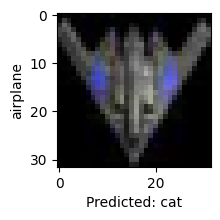

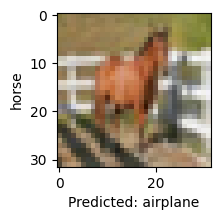

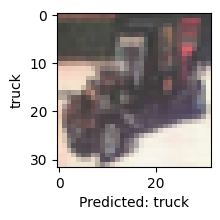

Test accuracy: 0.7459999918937683
Test loss: 0.7297808527946472


In [52]:
evaluate_model(model6, history6, x_test, y_test, 'model_6')

In [53]:
clear_session()

### Model 7

Adds another set of convolutional layers with 256 filters, increasing the depth and learning capacity of the network.

In [54]:
# Define the CNN model
model7 = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    GlobalAveragePooling2D(),  # Add a global average pooling layer
    Flatten(),  # Flatten the feature maps
    Dense(100, activation='relu'),  # Add a dense layer with 100 units
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [55]:
# Compile model
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history7 = model7.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test), callbacks=[early_stopping_callback()])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - accuracy: 0.3911 - loss: 1.7726 - val_accuracy: 0.1000 - val_loss: 3.3393
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.6465 - loss: 0.9927 - val_accuracy: 0.1181 - val_loss: 4.3446
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.7209 - loss: 0.7883 - val_accuracy: 0.1004 - val_loss: 4.5471
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.7751 - loss: 0.6456 - val_accuracy: 0.1344 - val_loss: 3.8274
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.8093 - loss: 0.5432 - val_accuracy: 0.3536 - val_loss: 2.2578
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.8394 - loss: 0.4565 - val_accuracy: 0.7144 - val_loss: 0.8258
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.8601 - loss: 0.3997 - val_accuracy: 0.7528 - val_loss: 0.7297
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.8847 - loss: 0.3298 - val_accu

#### Evaluation

Model 7's deeper architecture with more filters led to further improvements in accuracy. However, the training time likely increased due to the added complexity.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


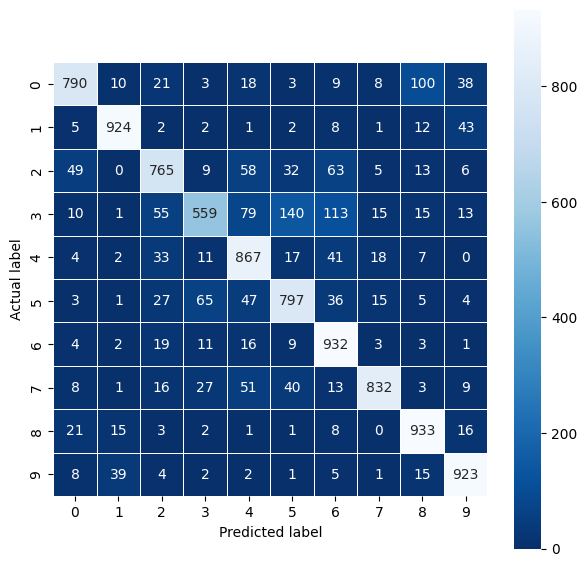

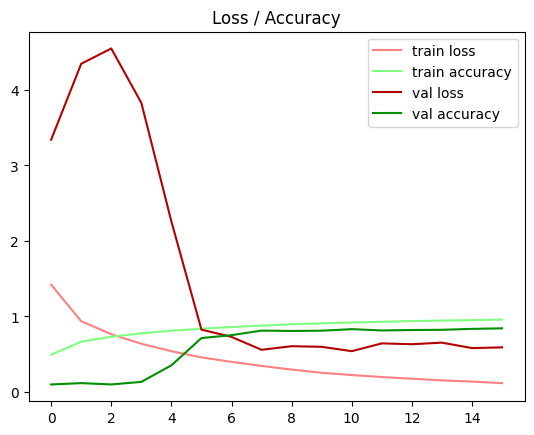

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1000
           1       0.93      0.92      0.93      1000
           2       0.81      0.77      0.79      1000
           3       0.81      0.56      0.66      1000
           4       0.76      0.87      0.81      1000
           5       0.76      0.80      0.78      1000
           6       0.76      0.93      0.84      1000
           7       0.93      0.83      0.88      1000
           8       0.84      0.93      0.89      1000
           9       0.88      0.92      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



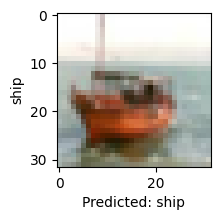

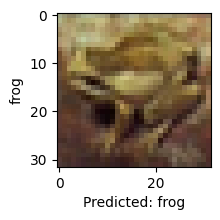

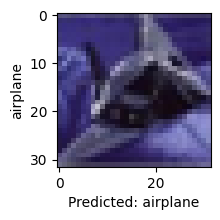

Test accuracy: 0.8321999907493591
Test loss: 0.5408172607421875


In [56]:
evaluate_model(model7, history7, x_test, y_test, 'model_7')

In [57]:
clear_session()

### Model 8

Maintains the architecture of Model 7 but reduces the batch size to 128, potentially leading to finer gradient updates during training.

In [58]:
# Define the CNN model
model8 = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    GlobalAveragePooling2D(),  # Add a global average pooling layer
    Flatten(),  # Flatten the feature maps
    Dense(100, activation='relu'),  # Add a dense layer with 100 units
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [59]:
# Compile model
model8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history8 = model8.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_test, y_test), callbacks=[early_stopping_callback()])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.4590 - loss: 1.5007 - val_accuracy: 0.1952 - val_loss: 3.0759
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.6981 - loss: 0.8459 - val_accuracy: 0.6918 - val_loss: 0.9281
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7735 - loss: 0.6411 - val_accuracy: 0.7441 - val_loss: 0.7258
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8186 - loss: 0.5204 - val_accuracy: 0.7514 - val_loss: 0.7432
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8476 - loss: 0.4367 - val_accuracy: 0.7733 - val_loss: 0.6917
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8723 - loss: 0.3646 - val_accuracy: 0.7853 - val_loss: 0.6542
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8885 - loss: 0.3208 - val_accuracy: 0.8159 - val_loss: 0.5865
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9082 - loss: 0.2613 - 

#### Evaluation

Reducing the batch size in Model 8 may have contributed to finer gradient updates during training. However, it's important to consider the trade-off between batch size and training time.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


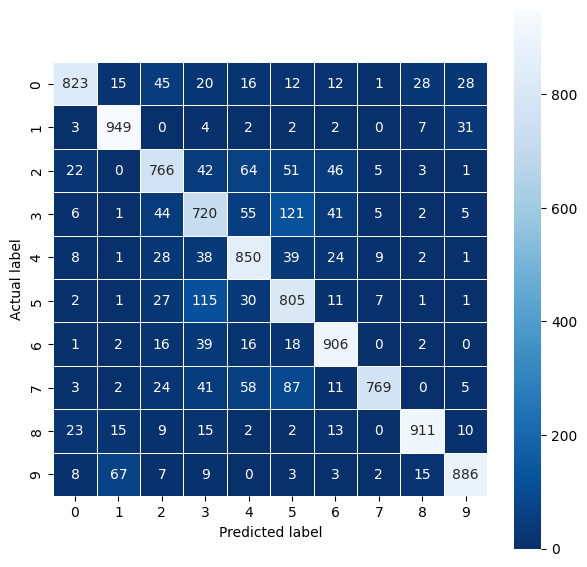

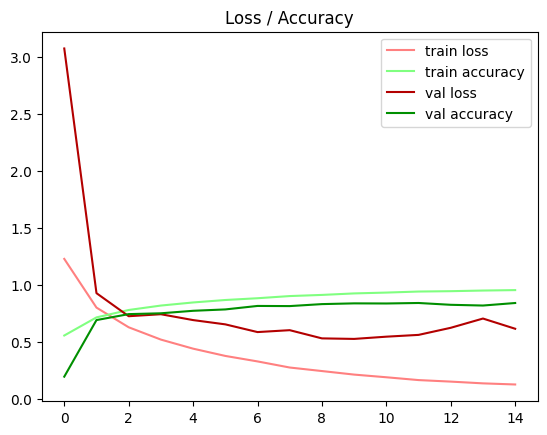

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1000
           1       0.90      0.95      0.92      1000
           2       0.79      0.77      0.78      1000
           3       0.69      0.72      0.70      1000
           4       0.78      0.85      0.81      1000
           5       0.71      0.81      0.75      1000
           6       0.85      0.91      0.88      1000
           7       0.96      0.77      0.86      1000
           8       0.94      0.91      0.92      1000
           9       0.92      0.89      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



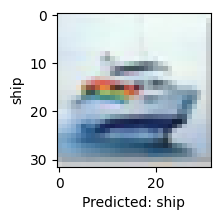

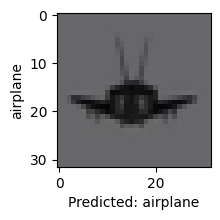

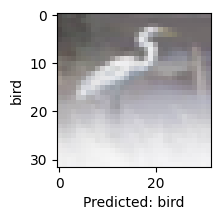

Test accuracy: 0.8385000228881836
Test loss: 0.5264580845832825


In [60]:
evaluate_model(model8, history8, x_test, y_test, 'model_8')

In [61]:
clear_session()

### Model 9

Employs ImageDataGenerator for data augmentation, introducing variations in the training data to improve robustness.

In [62]:
# Define the CNN model
model9 = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    GlobalAveragePooling2D(),  # Add a global average pooling layer
    Flatten(),  # Flatten the feature maps
    Dense(100, activation='relu'),  # Add a dense layer with 100 units
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [63]:
train_generator = image_data_generator().flow(x_train, y_train, batch_size=128)

# Compile model
model9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history9 = model9.fit(train_generator, epochs=30, validation_data=(x_test, y_test), callbacks=[early_stopping_callback()])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 57s 119ms/step - accuracy: 0.4155 - loss: 1.6173 - val_accuracy: 0.1815 - val_loss: 3.0560
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 67s 170ms/step - accuracy: 0.6487 - loss: 0.9937 - val_accuracy: 0.6804 - val_loss: 0.9402
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 65s 128ms/step - accuracy: 0.7196 - loss: 0.7940 - val_accuracy: 0.6883 - val_loss: 0.9097
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 71s 102ms/step - accuracy: 0.7645 - loss: 0.6746 - val_accuracy: 0.7297 - val_loss: 0.8167
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.7857 - loss: 0.6115 - val_accuracy: 0.6905 - val_loss: 0.9726
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.8085 - loss: 0.5471 - val_accuracy: 0.7481 - val_loss: 0.8024
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.8177 - loss: 0.5180 - val_accuracy: 0.7679 - val_loss: 0.7034
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.8357 - loss: 0.4739 - val

#### Evaluation

Data augmentation in Model 9 helped to improve the model's robustness and generalization ability. By introducing variations in the training data, it reduced the risk of overfitting.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


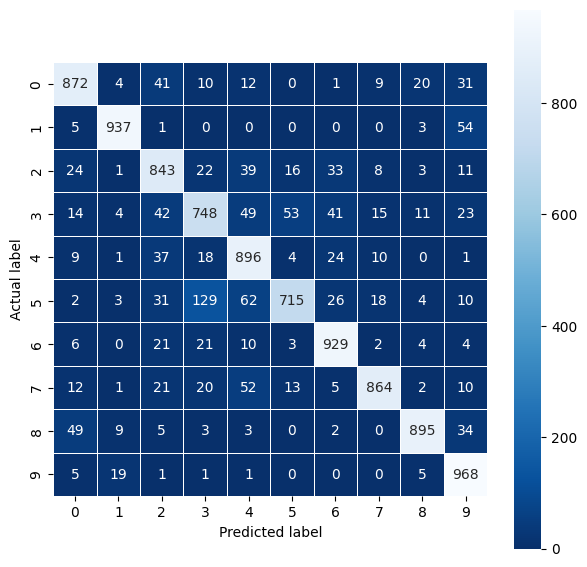

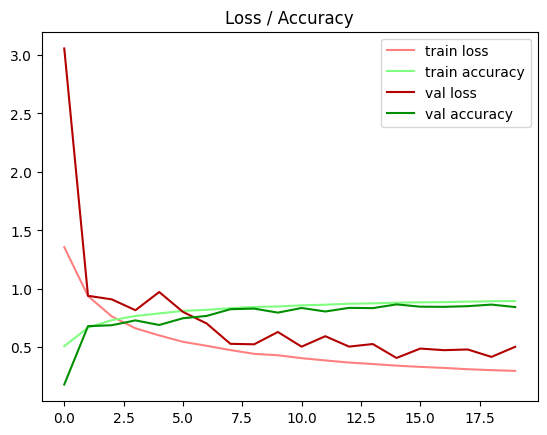

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1000
           1       0.96      0.94      0.95      1000
           2       0.81      0.84      0.83      1000
           3       0.77      0.75      0.76      1000
           4       0.80      0.90      0.84      1000
           5       0.89      0.71      0.79      1000
           6       0.88      0.93      0.90      1000
           7       0.93      0.86      0.90      1000
           8       0.95      0.90      0.92      1000
           9       0.84      0.97      0.90      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



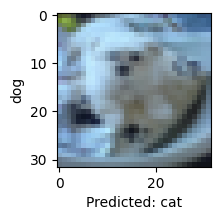

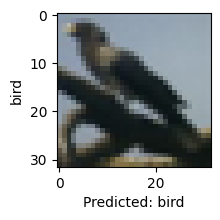

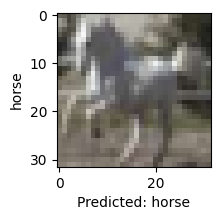

Test accuracy: 0.8666999936103821
Test loss: 0.4083370864391327


In [64]:
evaluate_model(model9, history9, x_test, y_test, 'model_9')

In [65]:
clear_session()

### Model 10

Combines data augmentation (ImageDataGenerator) with a reduced learning rate for the Adam optimizer, aiming for better convergence.

In [14]:
# Define the CNN model
model10 = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(),  # Normalize the activations of the previous layer
    MaxPooling2D((2, 2)),  # Add a max pooling layer
    Dropout(0.25),  # Set a Dropout of 0.25

    GlobalAveragePooling2D(),  # Add a global average pooling layer
    Flatten(),  # Flatten the feature maps
    Dense(100, activation='relu'),  # Add a dense layer with 100 units
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [15]:
train_generator = image_data_generator().flow(x_train, y_train, batch_size=128)

# change learning rate to 0.0001
optimizer = Adam(learning_rate=0.001)

# Compile model
model10.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history10 = model10.fit(train_generator, epochs=25, validation_data=(x_test, y_test), callbacks=[early_stopping_callback()])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 128ms/step - accuracy: 0.4316 - loss: 1.5745 - val_accuracy: 0.1703 - val_loss: 3.4116
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.6433 - loss: 0.9922 - val_accuracy: 0.6180 - val_loss: 1.1636
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.7166 - loss: 0.8019 - val_accuracy: 0.6771 - val_loss: 1.0056
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.7600 - loss: 0.6808 - val_accuracy: 0.7275 - val_loss: 0.8524
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.7868 - loss: 0.6076 - val_accuracy: 0.7247 - val_loss: 0.8759
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - accuracy: 0.8063 - loss: 0.5516 - val_accuracy: 0.7894 - val_loss: 0.6213
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - accuracy: 0.8227 - loss: 0.5082 - val_accuracy: 0.7525 - val_loss: 0.7937
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.8353 - loss: 0.4661 - val_accura

#### Evaluation

Combining data augmentation with a lower learning rate in Model 10 might have resulted in more stable and accurate training. This approach can be particularly useful for avoiding overshooting during optimization.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


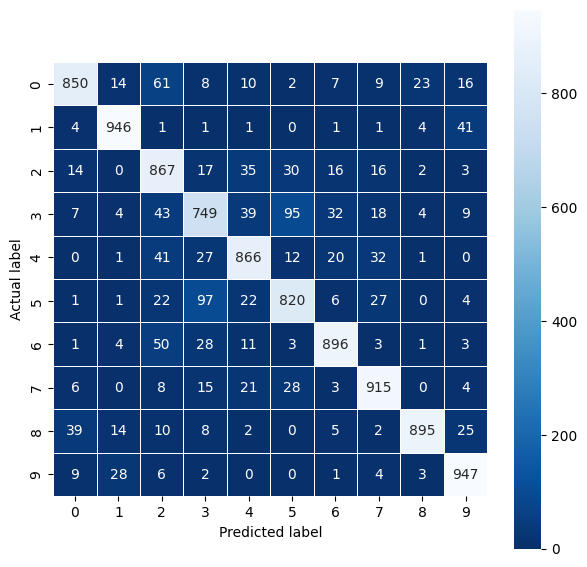

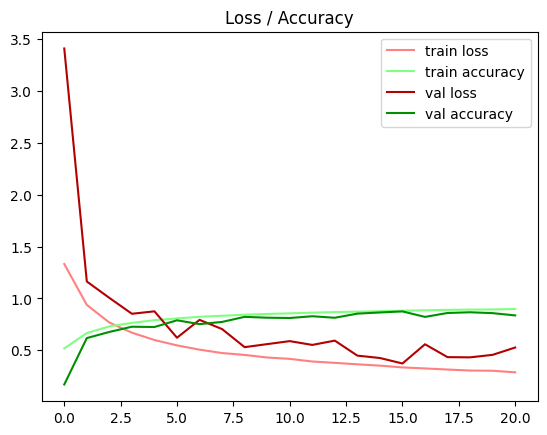

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1000
           1       0.93      0.95      0.94      1000
           2       0.78      0.87      0.82      1000
           3       0.79      0.75      0.77      1000
           4       0.86      0.87      0.86      1000
           5       0.83      0.82      0.82      1000
           6       0.91      0.90      0.90      1000
           7       0.89      0.92      0.90      1000
           8       0.96      0.90      0.93      1000
           9       0.90      0.95      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



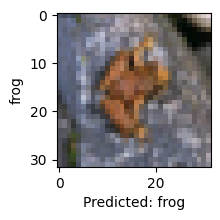

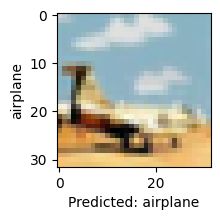

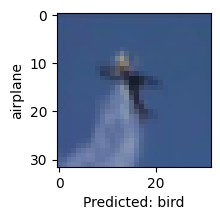

Test accuracy: 0.8751000165939331
Test loss: 0.37286096811294556


In [16]:
evaluate_model(model10, history10, x_test, y_test, 'model_10')

In [17]:
clear_session()

### Model 11

A deeper network, replicating the VGG architecture with multiple convolutional layers, BatchNormalization, and Dropout.

In [18]:
model11 = Sequential([
    Input(shape=(32, 32, 3)),  # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 64 filters
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  # Add a max pooling layer
    BatchNormalization(),  # Normalize the activations of the previous layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 128 filters
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  # Add a max pooling layer
    BatchNormalization(),  # Normalize the activations of the previous layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 256 filters
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 256 filters
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 256 filters
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  # Add a max pooling layer
    BatchNormalization(),  # Normalize the activations of the previous layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 512 filters
    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 512 filters
    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 512 filters
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  # Add a max pooling layer
    BatchNormalization(),  # Normalize the activations of the previous layer
    Dropout(0.25),  # Set a Dropout of 0.25

    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 512 filters
    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 512 filters
    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer with a 3x3 filter, 512 filters
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  # Add a max pooling layer
    BatchNormalization(),  # Normalize the activations of the previous layer
    Dropout(0.25),  # Set a Dropout of 0.25
    Flatten(),  # Flatten the feature maps
    Dense(4096, activation='relu'), # Add a dense layer with 4096 units
    Dropout(0.5),  # Set a Dropout of 0.5
    Dense(512, activation='relu'),  # Add a dense layer with 512 units
    Dropout(0.5),  # Set a Dropout of 0.5
    Dense(10, activation='softmax')  # Add the output classification layer with softmax activation for 10 classes
])

In [19]:
train_generator = image_data_generator().flow(x_train, y_train, batch_size=128)

# Compile model
model11.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history11 = model11.fit(train_generator, epochs=25, validation_data=(x_test, y_test), callbacks=[early_stopping_callback()])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 78s 152ms/step - accuracy: 0.2116 - loss: 2.1508 - val_accuracy: 0.1773 - val_loss: 2.6373
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.3601 - loss: 1.6567 - val_accuracy: 0.4151 - val_loss: 1.6104
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 114ms/step - accuracy: 0.4476 - loss: 1.4804 - val_accuracy: 0.5018 - val_loss: 1.5242
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.5173 - loss: 1.3568 - val_accuracy: 0.4478 - val_loss: 2.4341
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.5797 - loss: 1.2177 - val_accuracy: 0.5230 - val_loss: 1.7067
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 112ms/step - accuracy: 0.6223 - loss: 1.1183 - val_accuracy: 0.6342 - val_loss: 1.2185
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.6595 - loss: 1.0173 - val_accuracy: 0.6488 - val_loss: 1.0309
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 113ms/step - accuracy: 0.6853 - loss: 0.9670 - val

#### Evaluation

Model 11, inspired by the VGG architecture, achieved high accuracy, showcasing the power of deep convolutional networks. However, training such a complex model can be computationally demanding.

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


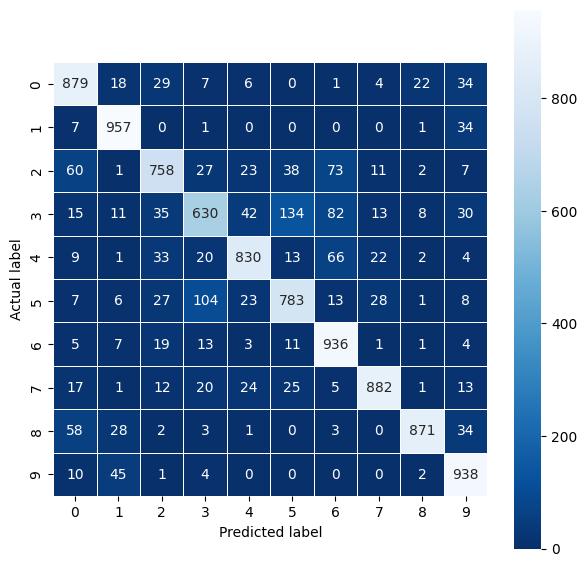

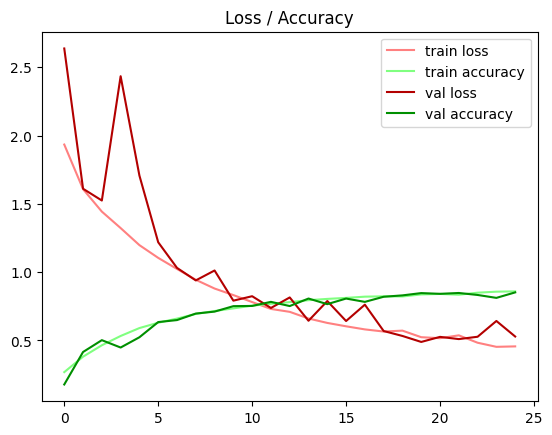

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1000
           1       0.89      0.96      0.92      1000
           2       0.83      0.76      0.79      1000
           3       0.76      0.63      0.69      1000
           4       0.87      0.83      0.85      1000
           5       0.78      0.78      0.78      1000
           6       0.79      0.94      0.86      1000
           7       0.92      0.88      0.90      1000
           8       0.96      0.87      0.91      1000
           9       0.85      0.94      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000



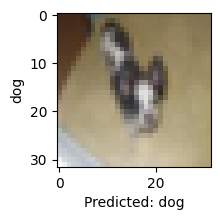

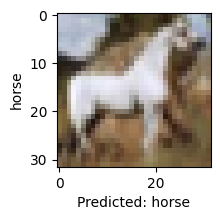

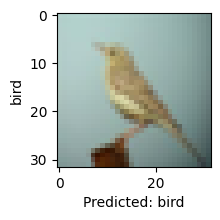

Test accuracy: 0.8464000225067139
Test loss: 0.48876404762268066


In [56]:
evaluate_model(model11, history11, x_test, y_test, 'model_11')

In [57]:
clear_session()

## Learning Transfer

### Model 12

Employs transfer learning with a pre-trained VGG16 model, keeping its weights frozen and adding new layers for CIFAR-10 classification with data augmentation.

In [20]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg16_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model12 = Sequential([
    vgg16_base,  # Pre-trained VGG16 base
    GlobalAveragePooling2D(),  # Add GlobalAveragePooling2D to handle varying input sizes
    Dense(10, activation='softmax')  # Add Dense layer for 10 CIFAR-10 classes
])

train_generator = image_data_generator().flow(x_train, y_train, batch_size=128)

# Compile the model with Adam optimizer and a learning rate of 0.001
optimizer = Adam(learning_rate=0.001)
model12.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history12 = model12.fit(train_generator, epochs=30, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.1968 - loss: 2.1203 - val_accuracy: 0.3985 - val_loss: 1.5432
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.4850 - loss: 1.3565 - val_accuracy: 0.6307 - val_loss: 1.0305
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - accuracy: 0.6315 - loss: 1.0383 - val_accuracy: 0.6838 - val_loss: 0.9433
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 113ms/step - accuracy: 0.7063 - loss: 0.8515 - val_accuracy: 0.7541 - val_loss: 0.7444
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.7456 - loss: 0.7535 - val_accuracy: 0.7645 - val_loss: 0.7354
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms/step - accuracy: 0.7704 - loss: 0.6936 - val_accuracy: 0.7910 - val_loss: 0.6469
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 80s 111ms/step - accuracy: 0.7911 - loss: 0.6358 - val_accuracy: 0.7980 - val_loss: 0.6367
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - accuracy: 0.7970 - loss: 0

#### Evaluation

Model 12 successfully demonstrated the benefits of transfer learning. By leveraging the pre-trained VGG16 weights, it achieved good accuracy despite not fine-tuning the base model.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


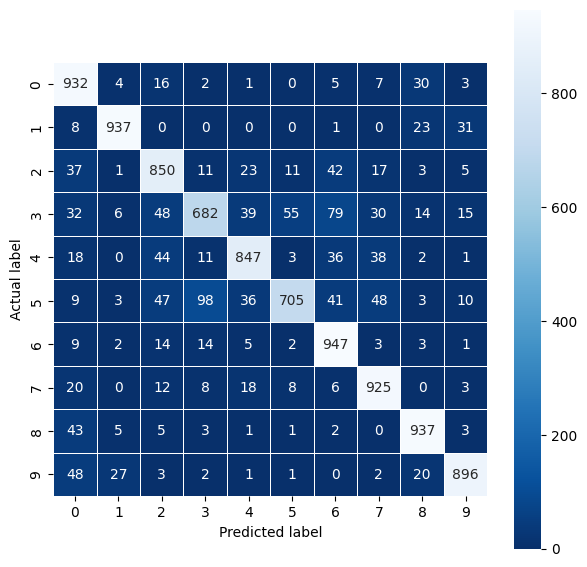

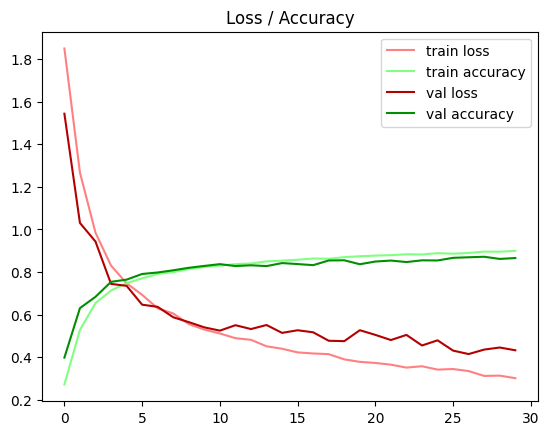

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1000
           1       0.95      0.94      0.94      1000
           2       0.82      0.85      0.83      1000
           3       0.82      0.68      0.74      1000
           4       0.87      0.85      0.86      1000
           5       0.90      0.70      0.79      1000
           6       0.82      0.95      0.88      1000
           7       0.86      0.93      0.89      1000
           8       0.91      0.94      0.92      1000
           9       0.93      0.90      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.86     10000



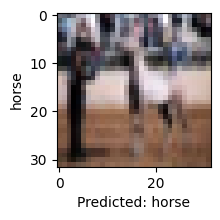

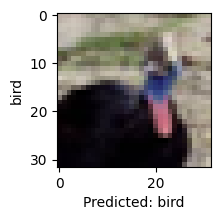

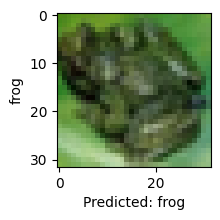

Test accuracy: 0.8658000230789185
Test loss: 0.4328845143318176


In [22]:
evaluate_model(model12, history12, x_test, y_test, 'model_12')

In [23]:
clear_session()

### Model 13

Utilizes transfer learning with VGG16 pre-trained on ImageNet. Fine-tuning is disabled (model12.trainable = False), leveraging the learned features for this specific task.

In [88]:
vgg16_base = VGG16(weights='imagenet', include_top=False, classes=10, input_shape=(32, 32, 3))
vgg16_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
vgg16_base.trainable = False

model13 = Sequential([
    vgg16_base,  # This is your pre-trained VGG16 base model
    Dense(128, activation='relu'),  # Add a dense layer with 128 units
    Dense(10, activation='softmax')  # Add the output layer for 10 classes (adjust for your number of classes)
])

model13.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [90]:
# To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using keras utilities

train_generator = image_data_generator().flow(x_train, y_train, batch_size=128)

history13 = model13.fit(train_generator, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 114ms/step - accuracy: 0.3747 - loss: 1.7717 - val_accuracy: 0.5362 - val_loss: 1.3279
Epoch 2/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.5281 - loss: 1.3606 - val_accuracy: 0.5635 - val_loss: 1.2485
Epoch 3/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.5483 - loss: 1.2978 - val_accuracy: 0.5686 - val_loss: 1.2392
Epoch 4/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.5589 - loss: 1.2571 - val_accuracy: 0.5647 - val_loss: 1.2310
Epoch 5/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.5716 - loss: 1.2313 - val_accuracy: 0.5775 - val_loss: 1.2003
Epoch 6/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.5733 - loss: 1.2159 - val_accuracy: 0.5891 - val_loss: 1.1826
Epoch 7/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.5762 - loss: 1.2079 - val_accuracy: 0.5841 - val_loss: 1.1843
Epoch 8/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.5805 - loss: 1.1998 - val_ac

#### Evaluation

This model likely involved fine-tuning the VGG16 model, allowing the pre-trained weights to be adjusted for the CIFAR-10 dataset. This approach can lead to higher accuracy compared to using the frozen base model in Model 12, but it also requires careful monitoring to avoid overfitting.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


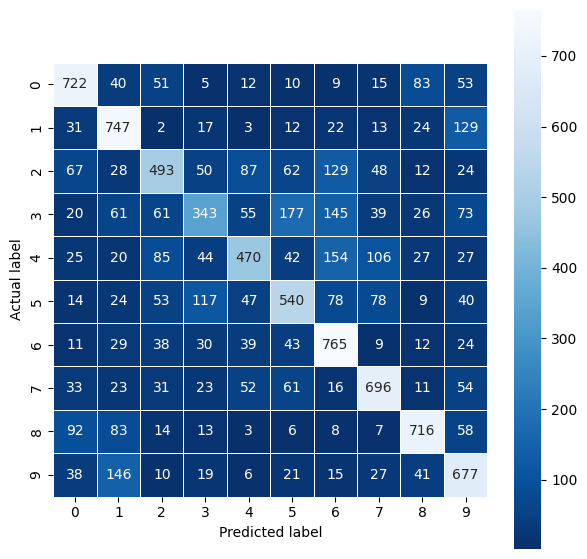

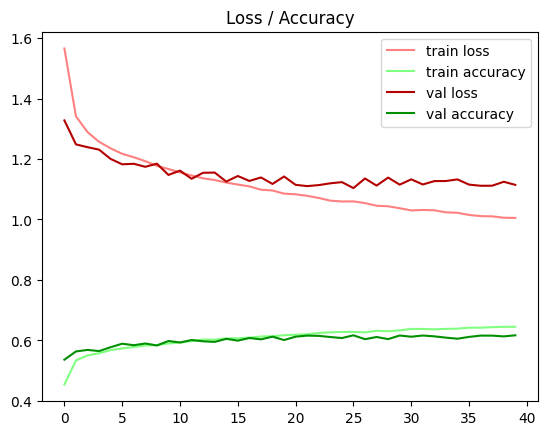

              precision    recall  f1-score   support

           0       0.69      0.72      0.70      1000
           1       0.62      0.75      0.68      1000
           2       0.59      0.49      0.54      1000
           3       0.52      0.34      0.41      1000
           4       0.61      0.47      0.53      1000
           5       0.55      0.54      0.55      1000
           6       0.57      0.77      0.65      1000
           7       0.67      0.70      0.68      1000
           8       0.75      0.72      0.73      1000
           9       0.58      0.68      0.63      1000

    accuracy                           0.62     10000
   macro avg       0.61      0.62      0.61     10000
weighted avg       0.61      0.62      0.61     10000



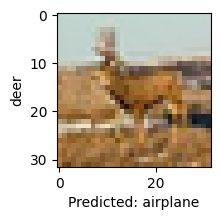

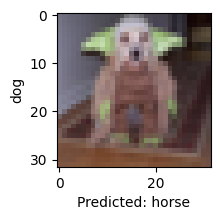

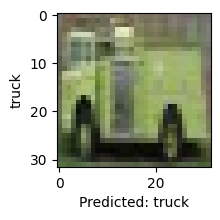

Test accuracy: 0.6169000267982483
Test loss: 1.1145991086959839


In [91]:
evaluate_model(model13, history13, x_test, y_test, 'model_13')

In [92]:
clear_session()

### Model 14

ResNet50 Tryout

In [45]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [46]:
# Freeze all Layers in Resnet Model
for layer in base_model.layers:
    layer.trainable = False

model14 = Sequential([
    base_model,  # This is your pre-trained ResNet base model (e.g., ResNet50)
    GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions
    Dense(128, activation='relu'),  # Add a dense layer with 128 units
    Dense(10, activation='softmax')  # Add the output layer for 10 classes (adjust for your number of classes)
])

model14.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

train_generator = image_data_generator().flow(x_train, y_train, batch_size=128)

history14 = model14.fit(train_generator, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 132ms/step - accuracy: 0.1613 - loss: 2.2970 - val_accuracy: 0.2837 - val_loss: 1.9730
Epoch 2/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.2661 - loss: 2.0122 - val_accuracy: 0.3168 - val_loss: 1.8852
Epoch 3/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.2891 - loss: 1.9510 - val_accuracy: 0.3360 - val_loss: 1.8490
Epoch 4/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.3071 - loss: 1.9099 - val_accuracy: 0.3484 - val_loss: 1.8220
Epoch 5/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.3152 - loss: 1.8926 - val_accuracy: 0.3667 - val_loss: 1.7891
Epoch 6/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.3272 - loss: 1.8606 - val_accuracy: 0.3586 - val_loss: 1.8012
Epoch 7/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.3339 - loss: 1.8484 - val_accuracy: 0.3811 - val_loss: 1.7495
Epoch 8/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.3401 - loss: 1.8344 - val_accur

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step


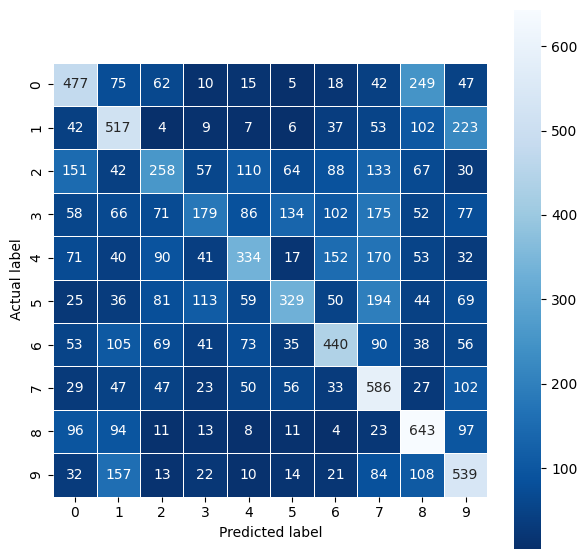

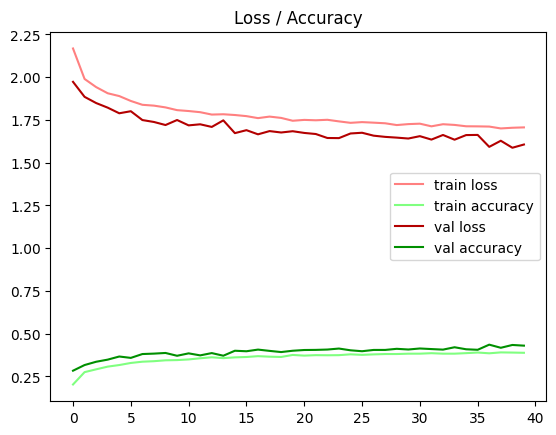

              precision    recall  f1-score   support

           0       0.46      0.48      0.47      1000
           1       0.44      0.52      0.47      1000
           2       0.37      0.26      0.30      1000
           3       0.35      0.18      0.24      1000
           4       0.44      0.33      0.38      1000
           5       0.49      0.33      0.39      1000
           6       0.47      0.44      0.45      1000
           7       0.38      0.59      0.46      1000
           8       0.46      0.64      0.54      1000
           9       0.42      0.54      0.47      1000

    accuracy                           0.43     10000
   macro avg       0.43      0.43      0.42     10000
weighted avg       0.43      0.43      0.42     10000



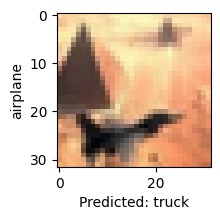

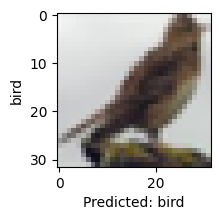

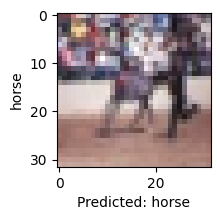

Test accuracy: 0.4302000105381012
Test loss: 1.6064488887786865


In [47]:
evaluate_model(model14, history14, x_test, y_test, 'model_14')

In [48]:
clear_session()

### Model 15

InceptionV3 tryout

In [49]:
# Resize images to 75x75 as it's required for InceptionV3
x_train_resized = resize_images(x_train, (75, 75))
x_test_resized = resize_images(x_test, (75, 75))

In [50]:
# Load the pre-trained InceptionV3 model without the top classification layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for our classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [51]:
# Create the final model
model15 = Model(inputs=base_model.input, outputs=predictions)

# Train the model with data augmentation
train_generator = image_data_generator().flow(x_train_resized, y_train, batch_size=128)

# Compile model
model15.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history15 = model15.fit(train_generator, epochs=30, validation_data=(x_test_resized, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 135s 302ms/step - accuracy: 0.4338 - loss: 1.6528 - val_accuracy: 0.5867 - val_loss: 1.2223
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 93s 235ms/step - accuracy: 0.5344 - loss: 1.3310 - val_accuracy: 0.6127 - val_loss: 1.1740
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 141s 233ms/step - accuracy: 0.5428 - loss: 1.2962 - val_accuracy: 0.6182 - val_loss: 1.1374
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 144s 235ms/step - accuracy: 0.5576 - loss: 1.2498 - val_accuracy: 0.6258 - val_loss: 1.1187
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 239ms/step - accuracy: 0.5662 - loss: 1.2291 - val_accuracy: 0.6233 - val_loss: 1.1233
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 95s 239ms/step - accuracy: 0.5716 - loss: 1.2101 - val_accuracy: 0.6234 - val_loss: 1.1144
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 141s 236ms/step - accuracy: 0.5771 - loss: 1.1897 - val_accuracy: 0.6298 - val_loss: 1.0963
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 95s 237ms/step - accuracy: 0.5821 - loss: 1.1866 

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step


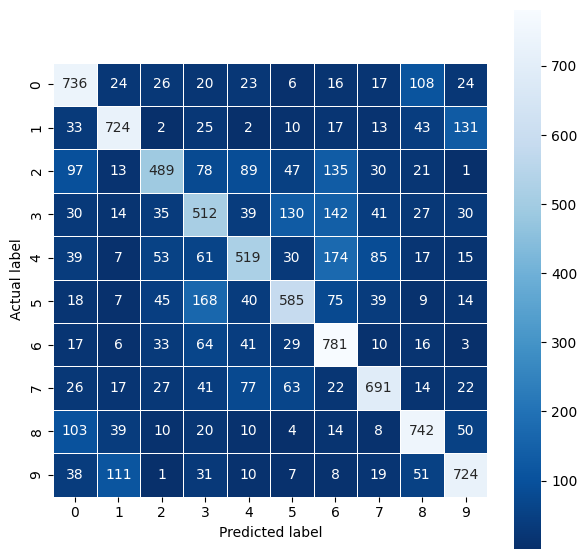

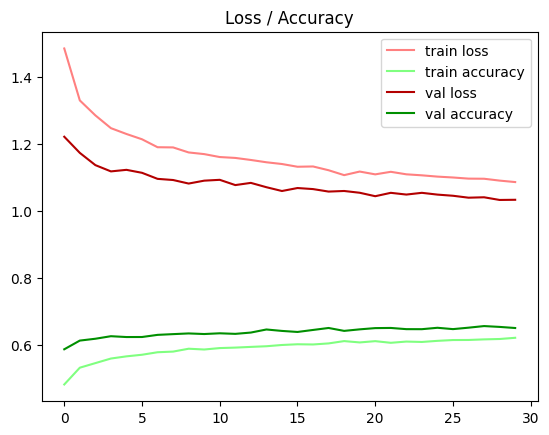

              precision    recall  f1-score   support

           0       0.65      0.74      0.69      1000
           1       0.75      0.72      0.74      1000
           2       0.68      0.49      0.57      1000
           3       0.50      0.51      0.51      1000
           4       0.61      0.52      0.56      1000
           5       0.64      0.58      0.61      1000
           6       0.56      0.78      0.66      1000
           7       0.73      0.69      0.71      1000
           8       0.71      0.74      0.72      1000
           9       0.71      0.72      0.72      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000



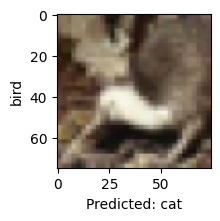

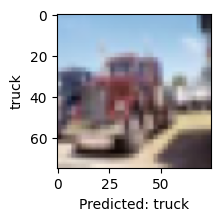

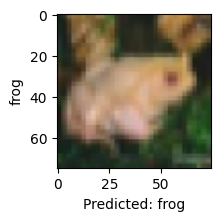

Test accuracy: 0.6503000259399414
Test loss: 1.0337544679641724


In [52]:
evaluate_model(model15, history15, x_test_resized, y_test, 'model_15')

In [ ]:
clear_session()

### Model 16

Test unfreezing the last 4 layers of the base VGG16 Model

In [93]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg16_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in vgg16_base.layers[-4:]:
    layer.trainable = True

model16 = Sequential([
    vgg16_base,  # Pre-trained VGG16 base
    GlobalAveragePooling2D(),  # Add GlobalAveragePooling2D to handle varying input sizes
    Dense(10, activation='softmax')  # Add Dense layer for 10 CIFAR-10 classes
])

train_generator = image_data_generator().flow(x_train, y_train, batch_size=128)

# Compile the model with Adam optimizer and a learning rate of 0.001
optimizer = Adam(learning_rate=0.0001)
model16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history16 = model16.fit(train_generator, epochs=30, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.5612 - loss: 1.2333 - val_accuracy: 0.7810 - val_loss: 0.6268
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.7663 - loss: 0.6707 - val_accuracy: 0.7893 - val_loss: 0.6136
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 113ms/step - accuracy: 0.8179 - loss: 0.5278 - val_accuracy: 0.8349 - val_loss: 0.4810
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.8411 - loss: 0.4628 - val_accuracy: 0.8372 - val_loss: 0.4836
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 49s 124ms/step - accuracy: 0.8573 - loss: 0.4084 - val_accuracy: 0.8451 - val_loss: 0.4592
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 113ms/step - accuracy: 0.8719 - loss: 0.3683 - val_accuracy: 0.8465 - val_loss: 0.4594
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 88s 128ms/step - accuracy: 0.8871 - loss: 0.3219 - val_accuracy: 0.8630 - val_loss: 0.4185
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.8955 - loss: 0.2982 - val

##### Evaluate

In [ ]:
evaluate_model(model16, history16, x_test, y_test, 'model_16')

In [ ]:
clear_session()